# Using bpnet-lite to traina CTCF profile model

In [6]:
import os
import torch
import bpnetlite
from pathlib import Path
from bpnetlite.io import extract_loci
from bpnetlite.io import PeakGenerator
from bpnetlite import BPNet

# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
reference_dir = "/cellar/users/aklie/data/eugene/avsec21/reference"
peaks = os.path.join(data_dir, "peaks.bed")
seqs = "/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa"
signals = [os.path.join(data_dir, "plus.bw"), os.path.join(data_dir, "minus.bw")]
controls = [os.path.join(data_dir, "control_plus.bw"), os.path.join(data_dir, "control_minus.bw")]

# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Load data

In [7]:
# Create a dataloader for the training peaks
training_data = PeakGenerator(peaks, seqs, signals, controls, chroms=training_chroms)

In [ ]:
# Check the shapes of the first batch
batch = next(iter(training_data))
batch[0].shape, batch[1].shape, batch[2].shape

In [ ]:
# Grab the validation data, no jittering, augmenting, or shuffling
X_valid, y_valid, X_ctl_valid = extract_loci(peaks, seqs, signals, controls, chroms=valid_chroms, max_jitter=0)
X_valid.shape, y_valid.shape, X_ctl_valid.shape

# Train a model

In [ ]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=2, n_control_tracks=2, trimming=(2114 - 1000) // 2).cuda()

In [ ]:
batch = next(iter(dl))
pred_ctl = model.forward(*batch[:2])

In [ ]:
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([8, 2, 1000]), torch.Size([8, 1]))

In [ ]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Use the models fit_generator method to train the model
res = model.fit_generator(
    training_data, 
    optimizer, 
    X_valid=X_valid, 
	X_ctl_valid=X_ctl_valid, 
    y_valid=y_valid
)

# Interpret the trained model

In [632]:
from bpnetlite.attributions import calculate_attributions

In [634]:
# Run if you haven't already
X_valid, y_valid, X_ctl_valid = extract_peaks(peaks, seqs, signals, controls, chroms=valid_chroms, max_jitter=0)
X_valid.shape, y_valid.shape, X_ctl_valid.shape

(torch.Size([7051, 4, 2114]),
 torch.Size([7051, 2, 1000]),
 torch.Size([7051, 2, 2114]))

In [636]:
models_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/avsec21/models"

In [644]:
pretrained_model = torch.load(os.path.join(models_dir, "bpnet.64.8.torch")).cuda()
X = X_valid[:32].cuda()
X_ctl = (torch.zeros(X.shape[0], 2, X.shape[-1]).cuda(), )
X.shape, X_ctl[0].shape

(torch.Size([32, 4, 2114]), torch.Size([32, 2, 2114]))

In [652]:
example_outs = pretrained_model(X, X_ctl[0])
example_outs[0].shape, example_outs[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

: 

In [650]:
X_attr = calculate_attributions(
    pretrained_model,
    X.cpu(),
    X_ctl
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [ ]:
import pandas as pd
import logomaker
def plot_attributions(X_attr, ax):
	"""Plot the attributions using logomaker.
	Takes in a matrix of attributions and plots the attribution-weighted
	sequence using logomaker. This is a convenience function.
	Parameters
	----------
	X_attr: torch.tensor, shape=(4, -1)
		A tensor of the attributions. Can be either the hypothetical
		attributions, where the entire matrix has values, or the projected
		attributions, where only the actual bases have their attributions
		stored, i.e., 3 values per column are zero.
	"""

	df = pd.DataFrame(X_attr.T, columns=['A', 'C', 'G', 'T'])
	df.index.name = 'pos'
	logo = logomaker.Logo(df, ax=ax)
	logo.style_spines(visible=False)
	return 

                 A    C             G    T
pos                                       
0     0.000000e+00  0.0  0.000000e+00  0.0
1    -2.066440e-13  0.0 -0.000000e+00  0.0
2     0.000000e+00  0.0  1.383642e-12  0.0
3     1.326429e-12 -0.0 -0.000000e+00 -0.0
4    -1.127276e-12  0.0  0.000000e+00  0.0
...            ...  ...           ...  ...
2109  1.179696e-12  0.0  0.000000e+00 -0.0
2110 -9.192583e-12  0.0 -0.000000e+00  0.0
2111 -5.749478e-12  0.0  0.000000e+00  0.0
2112  0.000000e+00  0.0  0.000000e+00  0.0
2113  0.000000e+00  0.0  0.000000e+00  0.0

[2114 rows x 4 columns]


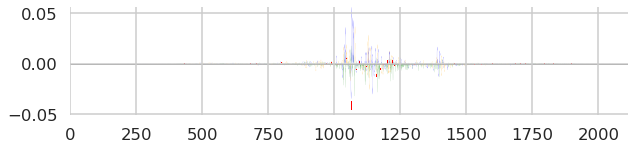

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plot_attributions(X_attr[0].detach().cpu().numpy(), ax)